# SAM3 Quick Start

Run Cell 1 once to load the model. Then run Cell 2 with different images/prompts.

In [1]:
# Cell 1: Load Model (run once)
import torch
from PIL import Image
from pathlib import Path
from transformers import Sam3Model, Sam3Processor
from utils import save_boxes_image, save_masks_image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESOLUTION = 1008

print(f"Device: {DEVICE}")
print("Loading SAM3 model...")

model = Sam3Model.from_pretrained("facebook/sam3").to(DEVICE, dtype=torch.bfloat16)
model.eval()

processor = Sam3Processor.from_pretrained("facebook/sam3")
processor.image_processor.size = {"height": RESOLUTION, "width": RESOLUTION}

print("Model loaded!")

Device: cuda
Loading SAM3 model...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Model loaded!


In [2]:
# Cell 2: Run Inference (change these and re-run)

IMAGE_PATH = r"D:\SAM\samples\D8_1.png"
TEXT_PROMPT = "nodes"
OUTPUT_DIR = r"D:\SAM\output"
THRESHOLD = 0.4
MASK_THRESHOLD = 0.5

# --- Run inference ---
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)
image_name = Path(IMAGE_PATH).stem

image = Image.open(IMAGE_PATH).convert("RGB")
print(f"Image: {IMAGE_PATH} ({image.width}x{image.height})")
print(f"Prompt: '{TEXT_PROMPT}'")

inputs = processor(images=image, text=TEXT_PROMPT, return_tensors="pt")
original_sizes = inputs.get("original_sizes").tolist()
inputs = inputs.to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_instance_segmentation(
    outputs,
    threshold=THRESHOLD,
    mask_threshold=MASK_THRESHOLD,
    target_sizes=original_sizes
)[0]

print(f"Found {len(results['masks'])} objects")

# Save outputs
save_boxes_image(image, results, str(output_dir / f"{image_name}_boxes.png"), title=f"'{TEXT_PROMPT}'")
save_masks_image(image, results, str(output_dir / f"{image_name}_masks.png"), title=f"'{TEXT_PROMPT}'")
print("Done!")

Image: D:\SAM\samples\D8_1.png (1888x2401)
Prompt: 'nodes'
Found 13 objects
Saved: D:\SAM\output\D8_1_boxes.png
Saved: D:\SAM\output\D8_1_masks.png
Done!


In [6]:
# Cell 3: Print all detected bboxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

boxes = results["boxes"]
scores = results["scores"]

print(f"Detected {len(boxes)} objects:\n")
print(f"{'Idx':<5} {'Score':<8} {'BBox [x1, y1, x2, y2]'}")
print("-" * 50)

for i, (box, score) in enumerate(zip(boxes, scores)):
    box_np = box.float().cpu().numpy()
    score_val = score.item()
    print(f"{i:<5} {score_val:<8.3f} [{box_np[0]:.0f}, {box_np[1]:.0f}, {box_np[2]:.0f}, {box_np[3]:.0f}]")

# Store for later use
DETECTED_BOXES = [(box.float().cpu().numpy(), score.item()) for box, score in zip(boxes, scores)]

Detected 13 objects:

Idx   Score    BBox [x1, y1, x2, y2]
--------------------------------------------------
0     0.820    [928, 592, 972, 636]
1     0.848    [1344, 2112, 1384, 2160]
2     0.816    [928, 1192, 972, 1240]
3     0.812    [1816, 2336, 1856, 2384]
4     0.816    [42, 2336, 84, 2384]
5     0.863    [928, 1912, 972, 1952]
6     0.809    [928, 48, 972, 86]
7     0.852    [450, 1912, 494, 1952]
8     0.832    [1616, 1020, 1656, 1056]
9     0.656    [1784, 936, 1888, 1040]
10    0.812    [928, 880, 972, 920]
11    0.809    [928, 1544, 972, 1584]
12    0.809    [928, 312, 972, 354]


Selected box 0: [928, 592, 972, 636] (score: 0.820)


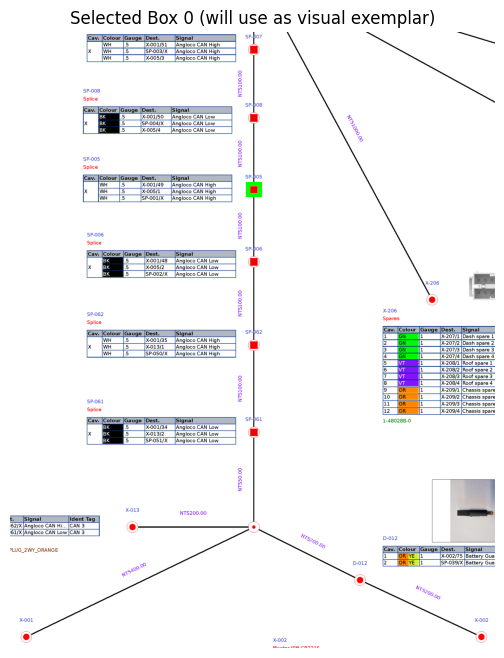

In [7]:
# Cell 4: Select a bbox and use it as visual exemplar
# Change SELECTED_BOX_IDX to pick different detected object

SELECTED_BOX_IDX = 0  # <-- Change this to select different bbox

selected_box, selected_score = DETECTED_BOXES[SELECTED_BOX_IDX]
x1, y1, x2, y2 = selected_box

print(f"Selected box {SELECTED_BOX_IDX}: [{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}] (score: {selected_score:.3f})")

# Show the selected box on image
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='lime', facecolor='none')
ax.add_patch(rect)
ax.set_title(f"Selected Box {SELECTED_BOX_IDX} (will use as visual exemplar)")
ax.axis('off')
plt.show()

Using box [[928, 592, 972, 636]] as visual exemplar...
Found 12 similar objects


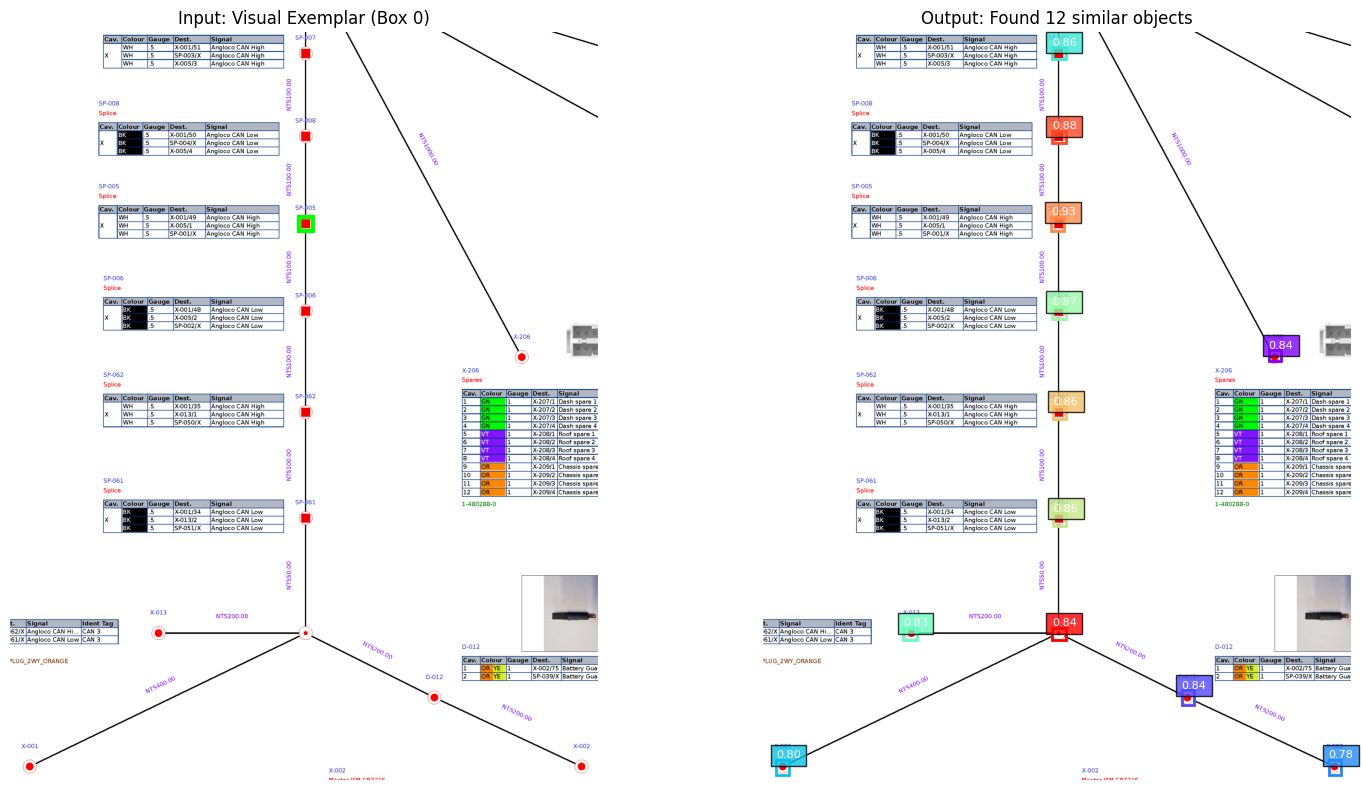

In [10]:
# Cell 5: Use selected bbox as visual exemplar to find similar objects
# This tells SAM3: "Find all objects that look like this box"

EXEMPLAR_THRESHOLD = 0.75  # Lower = more detections

# Convert to xyxy format as list
exemplar_box = [[int(x1), int(y1), int(x2), int(y2)]]
exemplar_label = [1]  # 1 = positive exemplar

print(f"Using box {exemplar_box} as visual exemplar...")

# Run inference with box prompt (no text)
inputs_box = processor(
    images=image,
    input_boxes=[exemplar_box],
    input_boxes_labels=[exemplar_label],
    return_tensors="pt"
)
original_sizes_box = inputs_box.get("original_sizes").tolist()

# Convert to device and bfloat16 (important: must match model dtype)
inputs_box = {k: v.to(DEVICE, dtype=torch.bfloat16) if v.dtype == torch.float32 else v.to(DEVICE) 
              for k, v in inputs_box.items()}

with torch.no_grad():
    outputs_box = model(**inputs_box)

results_box = processor.post_process_instance_segmentation(
    outputs_box,
    threshold=EXEMPLAR_THRESHOLD,
    mask_threshold=0.5,
    target_sizes=original_sizes_box
)[0]

print(f"Found {len(results_box['masks'])} similar objects")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Show exemplar box
axes[0].imshow(image)
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='lime', facecolor='none')
axes[0].add_patch(rect)
axes[0].set_title(f"Input: Visual Exemplar (Box {SELECTED_BOX_IDX})")
axes[0].axis('off')

# Show results
axes[1].imshow(image)
import matplotlib
n = max(len(results_box['boxes']), 1)
cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n)
for i, (box, score) in enumerate(zip(results_box['boxes'], results_box['scores'])):
    bx = box.float().cpu().numpy()
    rect = patches.Rectangle((bx[0], bx[1]), bx[2]-bx[0], bx[3]-bx[1], 
                              linewidth=2, edgecolor=cmap(i), facecolor='none')
    axes[1].add_patch(rect)
    axes[1].text(bx[0], bx[1]-5, f"{score.item():.2f}", color='white', fontsize=8,
                 bbox=dict(facecolor=cmap(i), alpha=0.8))
axes[1].set_title(f"Output: Found {len(results_box['boxes'])} similar objects")
axes[1].axis('off')

plt.tight_layout()
plt.show()

---
## Notes

**How Visual Exemplar Works**: SAM3 uses Promptable Concept Segmentation (PCS) - it learns the "concept" from your box and finds all similar objects.

**Advanced Options**:
- Multiple positive exemplars: `input_boxes_labels = [[1, 1]]`
- Positive + negative: `input_boxes_labels = [[1, 0]]` (find A, exclude B)
- Combined with text: Use text prompt + negative box to refine

See full documentation: `docs/sam3_visual_exemplar.md`